In [66]:
# Suzan Iloglu, Dec 11,2020
# Positive results from Pfizer, Moderna and AstraZeneca show a vaccine can work
# In this research, we wanna show the allocation of vaccine over the us by states and then by counties
# Import packages
import csv

from itertools import product
import geopandas as gpd
import pandas as pd
import numpy as np
import math
import time
import requests
import io
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
pd.options.display.max_columns =200
from IPython.display import Image
import sodapy
from sodapy import Socrata


# MAPPING THE VACCINE ALLOCATION
The project presents multiple options for how to distribute vaccine within each county per state. It shows that what you choose to prioritize greatly impacts where care would be sent. 
The followings are our options to choose to define vulnerability:


- SOCIAL VULNERABILITY INDEX
- MEDICAID 
- UNEMPLOYMENT
- YEARS OF POTENTIAL LIFE LOST
- TOTAL COVID CASES
- COVID CASES BY POPULATION
- COVID DEATHS BY POPULATION

We will start with Social Vulnerability Index (SVI) from CDC website.

### I. Importing SVI data which includes the variables for calculating county SVI for each state
The CDC uses both a USA-wide and a state by state SVI scores. For our project given that funding is likely going to be managed at a state level, using a state by state SVI scores makes the most sense and will be most sensitive to regional socioeconomic differences. Even though the CDC SVI scores are calculated using percentile rankings, the data sets include raw data estimates for each variables. The following table shows the variablaes used in the method of calculating SVI scores. 




      American Community Survey (ACS), 2015-2019 (5-year) data for the following estimates:
<img src="Data/img/SVI_comp.png" width="500">


Note: Full documentation for 2018 data is available <a href="https://svi.cdc.gov/data-and-tools-download.html">here</a> 
This part of the code shows preliminary mapping of <a href = "https://svi.cdc.gov/">the CDC's Social Vulnerability Index</a>.

Later in the notebook, we will provide the formula to create the SVI value we use in our project. First, we import the data for the US mainland and Puerto Rico.

In [67]:
## import svi data downloaded from CDC website as cited above

## 48 state SVI scores by county
#svi_counties_mainland = gpd.read_file("Data/SVI2018_US_COUNTY/SVI2018_US_county.shp")

## Puerto Rico SVI scores by county
#svi_counties_puerto_rico = gpd.read_file("Data/PuertoRico_COUNTY/SVI2018_PuertoRico_county.shp")

## Merge 48 states and Puerto Rico SVI 
#svi_counties = pd.concat([svi_counties_mainland,svi_counties_puerto_rico ], sort = False)
svi_counties =  pd.read_csv('Input/SVI_2019_State_Data.csv')
svi_counties.head(5)

,ST,COUNTY,STATE,FIPS,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR
0,1,Autauga County,Alabama,1001,594.4435,55380.0,NaN,23493,83,21397.0,325.0,8340,1000,936,246,29819,2345,4291.0,516.0,8283,85.0,13205,39.0,54552.0,232.0,947.0,188.2180,14065.0,NaN,419,228.2236,834,279.9589,4414,413,243,119.5073,941,198,565,162.0,15.2,1.8,3.7,1.0,29819,2345,11.5,1.4,15.0,0.2,23.8443,NaN,54552.0,NaN,4.4259,0.8771,25.3973,NaN,0.8033,0.4375,3.5500,1.1916,18.8,1.8,1.1357,0.5583,4.4,0.9,1.0202,NaN,0.2121,0.0606,0.0606,0.0758,0.4091,0.0455,0.1212,0.8939,0.6515,0.1515,1.8182,0.3182,0.4091,0.6667,1.0758,0.5455,0.7727,0.3636,0.2273,0.1364,0.1818,1.6818,0.0909,4.9848,0.0303,3856,561,7.1,1.0
1,1,Baldwin County,Alabama,1003,1589.8220,212830.0,NaN,114164,219,80930.0,1127.0,21704,1794,4226,580,32626,758,13893.0,1077.0,42531,194.0,46235,NaN,210305.0,474.0,4200.0,474.9874,36027.0,NaN,1425,486.4638,19766,1075.4023,12666,762,1042,301.4797,2656,360,3008,438.0,10.4,0.9,4.3,0.6,32626,758,9.2,0.7,20.0,0.1,21.7239,NaN,210305.0,NaN,5.1897,0.5824,16.9276,NaN,0.7085,0.2419,17.3137,0.9414,11.1,0.7,1.2875,0.3721,3.3,0.4,1.4133,NaN,0.0152,0.1364,0.0303,0.0455,0.2273,0.0152,0.7727,0.4091,0.9242,0.4394,2.5455,0.9697,0.2121,0.5909,0.8030,0.3182,1.0000,0.1364,0.3182,0.0455,0.4242,1.9242,0.1667,5.5000,0.0606,18679,1449,8.9,0.7
2,1,Barbour County,Alabama,1005,885.0076,25361.0,NaN,12013,143,9345.0,313.0,6875,558,849,176,18473,942,4812.0,333.0,4710,38.0,5307,27.0,22475.0,339.0,444.0,105.8017,13743.0,NaN,454,170.5696,208,86.0233,3520,255,360,157.1751,950,184,2886,339.0,30.7,2.4,9.2,1.9,18473,942,26.8,1.8,18.6,0.1,20.9258,NaN,22475.0,NaN,4.7512,1.1209,54.1895,NaN,1.8907,0.7103,1.7315,0.7158,29.3,2.0,3.8523,1.6770,10.2,2.0,11.3797,NaN,0.9545,0.7879,0.9394,1.0000,3.6818,0.9697,0.5152,0.1970,0.3636,0.3030,1.3788,0.0606,0.8333,0.9242,1.7576,1.0000,0.5000,0.8182,0.9697,0.8182,0.9848,4.0909,1.0000,10.9091,0.9848,2544,342,11.3,1.5
3,1,Bibb County,Alabama,1007,622.4611,22493.0,NaN,9185,68,6891.0,333.0,3740,939,659,248,20778,1703,3386.0,515.0,3584,61.0,4631,38.0,20632.0,201.0,356.0,133.0564,5730.0,NaN,71,103.0388,240,135.3255,2890,310,77,48.7545,425,170,1893,201.0,18.1,4.5,7.3,2.8,20778,1703,20.9,3.2,15.9,0.3,20.5886,NaN,20632.0,NaN,5.1662,1.9147,25.4746,NaN,0.3353,0.4865,2.6130,1.4732,31.5,3.4,1.1174,0.7054,6.2,2.4,8.4160,NaN,0.4545,0.6212,0.8333,0.8636,2.7727,0.7727,0.1818,0.1212,0.3182,0.4091,1.0303,0.0152,0.4242,0.3030,0.7273,0.2424,0.6364,0.8788,0.2121,0.5152,0.9394,3.1818,0.8788,7.7121,0.6061,2201,466,10.7,2.2
4,1,Blount County,Alabama,1009,644.8304,57681.0,NaN,24323,67,20847.0,394.0,7739,967,763,206,24747,1318,7763.0,647.0,10326,108.0,13389,56.0,57217.0,131.0,1117.0,219.6178,7560.0,NaN,878,245.7885,197,104.5610,6150,395,374,106.2309,860,221,551,124.0,13.6,1.7,3.4,0.9,24747,1318,19.5,1.6,17.9,0.2,23.2121,NaN,57217.0,NaN,5.3581,1.0486,13.1066,NaN,1.6185,0.4531,0.8099,0.4299,25.3,1.6,1.7940,0.5084,4.1,1.1,0.9553,NaN,0.0909,0.0152,0.3485,0.7121,1.1667,0.2121,0.4242,0.7879,0.6818,0.5455,2.4394,0.8788,0.1061,0.8788,0.9848,0.4697,0.2273,0.6364,0.6364,0.0909,0.1364,1.7273,0.1212,6.3182,0.1818,6159,810,10.8,1.4


In [68]:
## Create the list for State
S = svi_counties.STATE.unique().tolist()
if "0" in S:
    S.remove(0)
State = [str(s).strip() for s in S]
State

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming',
 'Puerto Rico']

In [69]:
## Replacing -999 values with 0 for calculations
svi_county = svi_counties.fillna(0)
svi_county  = svi_county.replace(-999, 0)
svi_county['FIPS'] = svi_county['FIPS'].astype(int)
svi_county.shape

(3220, 100)

In [70]:
# Create a seperate dictionary for the variables to calculate SVI

# Persons below poverty estimate, 2014-2018 ACS
E_POV = dict(zip(svi_county.FIPS, svi_county.E_POV))

# Civilian (age 16+) unemployed estimate, 2014-2018 ACS
E_UNEMP = dict(zip(svi_county.FIPS, svi_county.E_UNEMP))

# Per capita income estimate, 2014-2018 ACS
E_PCI = dict(zip(svi_county.FIPS, svi_county.E_PCI))

# Persons (age 25+) with no high school diploma estimate, 2014-2018 ACS
E_NOHSDP = dict(zip(svi_county.FIPS, svi_county.E_NOHSDP))

# Persons aged 65 and older estimate
E_AGE65 = dict(zip(svi_county.FIPS, svi_county.E_AGE65))

# Persons aged 17 and younger estimate
E_AGE17 = dict(zip(svi_county.FIPS, svi_county.E_AGE17))

# Population with a disability estimate
E_DISABL = dict(zip(svi_county.FIPS, svi_county.E_DISABL))

# Single parent households with children under 18 estimate
E_SNGPNT = dict(zip(svi_county.FIPS, svi_county.E_SNGPNT))

# Minority (all persons except white, nonHispanic) estimate, 2014-2018 ACS
E_MINRTY = dict(zip(svi_county.FIPS, svi_county.E_MINRTY))

# Persons (age 5+) who speak English "less than well" estimate, 2014-2018 ACS
E_LIMENG = dict(zip(svi_county.FIPS, svi_county.E_LIMENG))

# Housing in structures with 10 or more units estimate, 2014-2018 ACS
E_MUNIT = dict(zip(svi_county.FIPS, svi_county.E_MUNIT))

# Mobile homes estimate MOE, 2014-2018 ACS
E_MOBILE = dict(zip(svi_county.FIPS, svi_county.E_MOBILE))

# At household level (occupied housing units), more people than rooms estimate, 2014-2018 ACS
E_CROWD = dict(zip(svi_county.FIPS, svi_county.E_CROWD))

# Households with no vehicle available estimate, 2014-2018 ACS
E_NOVEH = dict(zip(svi_county.FIPS, svi_county.E_NOVEH))

# Persons in institutionalized group quarters estimate, 2014-2018 ACS
E_GROUPQ = dict(zip(svi_county.FIPS, svi_county.E_GROUPQ))

# Percentage of persons below poverty estimate
E_POV = dict(zip(svi_county.FIPS, svi_county.E_POV))

In [71]:
df_mmm = pd.read_csv("Input/ACSST5Y2019.S2704_data_with_overlays_2020-12-11T225641.csv", header=[1])
df_mmm.head(1)
#df_mmm.dtypes

,id,Geographic Area Name,Estimate!!Total!!Civilian noninstitutionalized population,Margin of Error!!Total!!Civilian noninstitutionalized population,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!65 years and over,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!65 years and over,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!65 years and over,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Below 138 percent of the poverty threshold,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Below 138 percent of the poverty threshold,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!At or above 138 percent of the poverty threshold,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!At or above 138 percent of the poverty threshold,"Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Worked full-time, year-round (19-64 years)","Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Worked full-time, year-round (19-64 years)",Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Under 6,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Under 6,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!6 to 18 years,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!6 to 18 years,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALON

In [72]:

pandemic_i = pd.read_csv("https://raw.githubusercontent.com/COVID19PVI/data/master/Model11.2.1/Model_11.2.1_20201215_results.csv")

#pandemic_index[['Name','NAME']] = pandemic_index['Name'].str.split(',',expand=True)
pandemic_i.head(5)

,ToxPi Score,HClust Group,KMeans Group,Name,Source,Infection Rate: Transmissible Cases!25!0xcc3333ff,Infection Rate: Disease Spread!5!0xe64d4dff,Pop Concentration: Pop Mobility!10!0x57b757ff,Pop Concentration: Residential Density!10!0x5ced5cff,Intervention: Social Distancing!10!0x4258c9ff,Intervention: Testing!10!0x6079f7ff,Health & Environment: Pop Demographics!10!0x6b0b9eff,Health & Environment: Air Pollution!10!0x8e26c4ff,Health & Environment: Age Distribution!10!0x9a42c8ff,Health & Environment: Co-morbidities!10!0xb460e0ff,Health & Environment: Health Disparities!10!0xc885ecff,Health & Environment: Hospital Beds!5!0xdeb9f1ff
0,0.638253,7,1,"Mississippi, Neshoba","-89.1173,32.7534",0.673873,0.164261,0.540407,0.8316,0.750,0.766526,0.907980,0.443114,0.521532,0.607214,0.612941,0.460080
1,0.635230,7,8,"Alabama, Talladega","-86.1689,33.3782",0.645233,0.220816,0.578332,0.7985,1.000,0.867080,0.597357,0.508982,0.560557,0.560892,0.541342,0.407683
2,0.634814,7,8,"Virginia, Galax City","-80.917,36.666",0.731868,0.200097,0.703484,0.9188,1.000,0.746181,0.441340,0.335329,0.666136,0.473758,0.628630,0.183602
3,0.634474,7,8,"Kansas, Wyandotte","-94.7638,39.1173",0.681493,0.186529,0.713249,0.6686,1.000,0.938396,0.674713,0.425150,0.419125,0.474933,0.657392,0.324750
4,0.628516,7,1,"Mississippi, Leake","-89.524,32.7537",0.657959,0.182865,0.451002,0.9220,0.675,0.766526,0.881904,0.425150,0.511724,0.536734,0.673518,0.553126


In [73]:
pandemic_input = pd.read_csv("https://raw.githubusercontent.com/COVID19PVI/data/master/Model11.2.1/Model_11.2.1_20201216_data.csv", header = [12])


pandemic_input.head(5)


,row,sid,casrn,name,Spread,Sick,PctCases,Cases,CountyCaseRate,StateCaseRate,PctDeaths,Deaths,PctDeaths2,CountyDeathRate,StateDeathRate,StatePctTested,StateTestRate,SVISocioeconomic,SVIMinority,SVIHousing,PctBeds,Mobility,PctNoIns,PctGE65,DaytimePopDensity,PrematureDeath,Smoking,AirPollution,Diabetes,Traffic,DistancingGrade,Obesity,PctBlack,PctNative
0,1,"-86.6441,32.5395",1001,"Alabama, Autauga",0.177466,10.935055,0.061618,3426,1.014996,1.012372,0.012551,43,0.000773,1.006827,1.006616,0.354384,1.005746,0.3631,0.5947,0.3741,0.001529,1733.08,7.1,14.6,76.0,8128.591190,0.180816,11.7,0.111,88.457040,5.0,0.333,0.193432,0.004802
1,2,"-87.7221,30.7277",1003,"Alabama, Baldwin",0.181720,9.219253,0.050733,11061,1.014887,1.012372,0.012747,141,0.000647,1.000000,1.006616,0.354384,1.005746,0.2232,0.4358,0.3359,0.001523,1971.57,10.2,19.5,121.0,7354.122530,0.174890,10.3,0.107,86.997430,5.0,0.310,0.087840,0.007724
2,3,"-85.3871,31.8683",1005,"Alabama, Barbour",0.079721,4.139705,0.051927,1292,1.005886,1.012372,0.023220,30,0.001206,1.000000,1.006616,0.354384,1.005746,0.9780,0.8558,0.9889,0.002974,1080.54,11.2,18.0,27.5,10253.573403,0.220000,11.5,0.176,102.291762,3.7,0.417,0.480326,0.006591
3,4,"-87.1251,32.9964",1007,"Alabama, Bibb",0.199468,13.392857,0.067143,1504,1.019148,1.012372,0.025931,39,0.001741,1.000000,1.006616,0.354384,1.005746,0.7694,0.4323,0.7189,0.001563,1272.47,7.9,16.3,28.9,11977.539484,0.191142,11.2,0.145,29.335580,4.0,0.376,0.211205,0.004375
4,5,"-86.5679,33.9821",1009,"Alabama, Blount",0.211286,14.177040,0.067099,3881,1.017974,1.012372,0.012626,49,0.000847,1.009066,1.006616,0.354384,1.005746,0.6143,0.5915,0.1741,0.000692,1395.46,11.0,17.8,71.7,11335.071134,0.192087,11.7,0.170,33.411782,4.3,0.338,0.014627,0.006535


In [74]:
pandemic_in = pd.merge(left = pandemic_i, right = pandemic_input[['sid', 'casrn']], how = 'left', left_on = 'Source', right_on = 'sid')

pandemic_in.head(5)



,ToxPi Score,HClust Group,KMeans Group,Name,Source,Infection Rate: Transmissible Cases!25!0xcc3333ff,Infection Rate: Disease Spread!5!0xe64d4dff,Pop Concentration: Pop Mobility!10!0x57b757ff,Pop Concentration: Residential Density!10!0x5ced5cff,Intervention: Social Distancing!10!0x4258c9ff,Intervention: Testing!10!0x6079f7ff,Health & Environment: Pop Demographics!10!0x6b0b9eff,Health & Environment: Air Pollution!10!0x8e26c4ff,Health & Environment: Age Distribution!10!0x9a42c8ff,Health & Environment: Co-morbidities!10!0xb460e0ff,Health & Environment: Health Disparities!10!0xc885ecff,Health & Environment: Hospital Beds!5!0xdeb9f1ff,sid,casrn
0,0.638253,7,1,"Mississippi, Neshoba","-89.1173,32.7534",0.673873,0.164261,0.540407,0.8316,0.750,0.766526,0.907980,0.443114,0.521532,0.607214,0.612941,0.460080,"-89.1173,32.7534",28099
1,0.635230,7,8,"Alabama, Talladega","-86.1689,33.3782",0.645233,0.220816,0.578332,0.7985,1.000,0.867080,0.597357,0.508982,0.560557,0.560892,0.541342,0.407683,"-86.1689,33.3782",1121
2,0.634814,7,8,"Virginia, Galax City","-80.917,36.666",0.731868,0.200097,0.703484,0.9188,1.000,0.746181,0.441340,0.335329,0.666136,0.473758,0.628630,0.183602,"-80.917,36.666",51640
3,0.634474,7,8,"Kansas, Wyandotte","-94.7638,39.1173",0.681493,0.186529,0.713249,0.6686,1.000,0.938396,0.674713,0.425150,0.419125,0.474933,0.657392,0.324750,"-94.7638,39.1173",20209
4,0.628516,7,1,"Mississippi, Leake","-89.524,32.7537",0.657959,0.182865,0.451002,0.9220,0.675,0.766526,0.881904,0.425150,0.511724,0.536734,0.673518,0.553126,"-89.524,32.7537",28079


In [75]:
PVI_county = dict(zip(pandemic_in.casrn, pandemic_in['ToxPi Score']))


In [76]:
ADI =  pd.read_csv('Input/ADI_2019.csv')
ADI.head(5)

,GEOID,NAME,STATE,ADI_US,ADI_ST,ADI_US_Scaled,ADI_ST_Scaled,st,ADI_US_rank,ADI_ST_rank
0,1001,Autauga County,Alabama,90.180531,68.898514,40.14,4.86,1,5,5.0
1,1003,Baldwin County,Alabama,83.132327,55.593936,36.20,4.70,1,2,2.0
2,1005,Barbour County,Alabama,133.749446,129.732504,64.48,5.58,1,64,64.0
3,1007,Bibb County,Alabama,111.576263,100.930506,52.09,5.24,1,33,33.0
4,1009,Blount County,Alabama,101.762939,87.270465,46.61,5.08,1,13,14.0


In [77]:
df_mmm['FIPS'] = df_mmm.id.astype(str).str[9:]
df_mmm.head(5)
df_mmm.FIPS.astype(int)
df_mmm['FIPS'] = pd.to_numeric(df_mmm['FIPS'])

In [78]:
#2019 ADI data
ADI_county  = dict(zip(df_mmm['FIPS'], df_mmm["Estimate!!Public Coverage!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination"]))

df_a = pd.read_csv("Input/ACSST5Y2019.S0101_data_with_overlays_2020-12-15T094007.csv", header=[1])
df_a.head(1)


# 2018
# ADI_total  = dict(zip(df_mmm['FIPS'], df_mmm["Estimate!!Public Coverage!!Medicaid/means-tested public coverage alone or in combination"]))

,id,FIPS,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Margin of Error!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 9 years,Margin of Error!!Total!!Total population!!AGE!!5 to 9 years,Estimate!!Total!!Total population!!AGE!!10 to 14 years,Margin of Error!!Total!!Total population!!AGE!!10 to 14 years,Estimate!!Total!!Total population!!AGE!!15 to 19 years,Margin of Error!!Total!!Total population!!AGE!!15 to 19 years,Estimate!!Total!!Total population!!AGE!!20 to 24 years,Margin of Error!!Total!!Total population!!AGE!!20 to 24 years,Estimate!!Total!!Total population!!AGE!!25 to 29 years,Margin of Error!!Total!!Total population!!AGE!!25 to 29 years,Estimate!!Total!!Total population!!AGE!!30 to 34 years,Margin of Error!!Total!!Total population!!AGE!!30 to 34 years,Estimate!!Total!!Total population!!AGE!!35 to 39 years,Margin of Error!!Total!!Total population!!AGE!!35 to 39 years,Estimate!!Total!!Total population!!AGE!!40 to 44 years,Margin of Error!!Total!!Total population!!AGE!!40 to 44 years,Estimate!!Total!!Total population!!AGE!!45 to 49 years,Margin of Error!!Total!!Total population!!AGE!!45 to 49 years,Estimate!!Total!!Total population!!AGE!!50 to 54 years,Margin of Error!!Total!!Total population!!AGE!!50 to 54 years,Estimate!!Total!!Total population!!AGE!!55 to 59 years,Margin of Error!!Total!!Total population!!AGE!!55 to 59 years,Estimate!!Total!!Total population!!AGE!!60 to 64 years,Margin of Error!!Total!!Total population!!AGE!!60 to 64 years,Estimate!!Total!!Total population!!AGE!!65 to 69 years,Margin of Error!!Total!!Total population!!AGE!!65 to 69 years,Estimate!!Total!!Total population!!AGE!!70 to 74 years,Margin of Error!!Total!!Total population!!AGE!!70 to 74 years,Estimate!!Total!!Total population!!AGE!!75 to 79 years,Margin of Error!!Total!!Total population!!AGE!!75 to 79 years,Estimate!!Total!!Total population!!AGE!!80 to 84 years,Margin of Error!!Total!!Total population!!AGE!!80 to 84 years,Estimate!!Total!!Total population!!AGE!!85 years and over,Margin of Error!!Total!!Total population!!AGE!!85 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!5 to 14 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!5 to 14 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 17 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 17 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 to 24 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 to 24 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 44 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 44 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!16 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!16 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!21 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!21 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!60 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!60 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!62 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!62 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over,Estimate!!Total!!Total popul

In [79]:
#Adult population
Sixty_five_plus_pop = dict(zip(df_a['FIPS'], df_a["Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over"]))
Sixty_five_plus_pop

{1001: 8283,
 1003: 42531,
 1005: 4710,
 1007: 3584,
 1009: 10326,
 1011: 1640,
 1013: 3900,
 1015: 19738,
 1017: 6470,
 1019: 5811,
 1021: 7052,
 1023: 2922,
 1025: 4679,
 1027: 2698,
 1029: 2899,
 1031: 8550,
 1033: 10644,
 1035: 2746,
 1037: 2430,
 1039: 7726,
 1041: 2609,
 1043: 15116,
 1045: 8081,
 1047: 6809,
 1049: 11883,
 1051: 12053,
 1053: 6566,
 1055: 19257,
 1057: 3438,
 1059: 5304,
 1061: 5275,
 1063: 1773,
 1065: 2777,
 1067: 3785,
 1069: 18052,
 1071: 10113,
 1073: 101785,
 1075: 2983,
 1077: 18228,
 1079: 5998,
 1081: 18696,
 1083: 14328,
 1085: 1856,
 1087: 3614,
 1089: 53151,
 1091: 3729,
 1093: 6288,
 1095: 16093,
 1097: 65339,
 1099: 4100,
 1101: 33107,
 1103: 20412,
 1105: 1772,
 1107: 3739,
 1109: 4946,
 1111: 4622,
 1113: 8029,
 1115: 14317,
 1117: 31716,
 1119: 2234,
 1121: 14052,
 1123: 8505,
 1125: 26673,
 1127: 12191,
 1129: 3047,
 1131: 2026,
 1133: 5075,
 2013: 318,
 2016: 347,
 2020: 30873,
 2050: 1301,
 2060: 87,
 2068: 209,
 2070: 499,
 2090: 9699,
 2100

In [80]:
df_a = df_a.rename(columns = {"Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over":'Adult_pop'})
df_a.head(5)
df_a.shape


(3220, 459)

In [81]:
#Adult population
Adult_pop_county = dict(zip(df_a['FIPS'], df_a["Adult_pop"]))
Adult_pop_county

{1001: 42175,
 1003: 166595,
 1005: 20054,
 1007: 17862,
 1009: 44292,
 1011: 8120,
 1013: 15373,
 1015: 89666,
 1017: 26595,
 1019: 20658,
 1021: 33420,
 1023: 10322,
 1025: 18841,
 1027: 10559,
 1029: 11533,
 1031: 39403,
 1033: 43218,
 1035: 9790,
 1037: 8956,
 1039: 29037,
 1041: 10738,
 1043: 64148,
 1045: 37892,
 1047: 29720,
 1049: 53800,
 1051: 62915,
 1053: 28769,
 1055: 80579,
 1057: 13014,
 1059: 23582,
 1061: 20599,
 1063: 6440,
 1065: 11355,
 1067: 13537,
 1069: 80349,
 1071: 40870,
 1073: 508503,
 1075: 10835,
 1077: 74247,
 1079: 25875,
 1081: 126764,
 1083: 73144,
 1085: 7808,
 1087: 15460,
 1089: 282589,
 1091: 14918,
 1093: 23592,
 1095: 71756,
 1097: 316303,
 1099: 16522,
 1101: 173501,
 1103: 91846,
 1105: 7286,
 1107: 16212,
 1109: 26863,
 1111: 17751,
 1113: 43783,
 1115: 67948,
 1117: 162807,
 1119: 10327,
 1121: 63130,
 1123: 32072,
 1125: 163687,
 1127: 49854,
 1129: 12753,
 1131: 8104,
 1133: 18858,
 2013: 2901,
 2016: 4716,
 2020: 221655,
 2050: 11740,
 2060:

In [82]:
#Total number of health workers

Health_workers = pd.read_csv("Input/Healthcare_Personnel_2018.csv")

Health_workers = pd.merge(Health_workers, svi_county[['FIPS']], how='right', on=['FIPS'])
Health_workers['FIPS'] = Health_workers['FIPS'].astype(str)
Health_workers.fillna(0, inplace=True)
Health_workers.head(5)
Health_workers.shape

(3220, 9)

In [83]:
Health_workers.dtypes

GEO_ID              object
FIPS                object
NAME                object
STATE               object
NAICS2017          float64
NAICS2017_LABEL     object
EMPSZES_LABEL       object
YEAR               float64
EMP                float64
dtype: object

In [84]:
import folium
import json
import pandas as pd
import os

#county_geo = os.path.join('Input/us-county-boundaries.json')
#county_geo

In [85]:
Assistant_Living = pd.read_csv("Input/Assistant_Living.csv")

Assistant_Living['FIPS'] = Assistant_Living['FIPS'].astype(str)

Assistant_Living['est_patients'] = Assistant_Living['est_patients'].replace(math.nan, 0)


# Population

In [86]:


#first_phase = pd.merge(Health_workers, Assistant_Living, how='outer', on=['FIPS'])
#first_phase.fillna(0, inplace=True)

#sum_column = first_phase["EMP"] + first_phase["est_patients"]
#first_phase["one_a"] = sum_column

first_phase = pd.read_csv("Input/Phase_1a_pop.csv")

first_phase['FIPS'] = first_phase['FIPS'].astype(int)
first_phase.head(5)

,FIPS,hp_emp,ltcf_res,phase_1a
0,1001,1037,120,1157
1,1003,7214,680,7894
2,1005,422,143,565
3,1007,418,119,537
4,1009,661,202,863


In [87]:
Firstphase_county = dict(zip(first_phase.FIPS, first_phase.phase_1a))

In [88]:
from collections import Counter
Asistant_Living_county = dict(zip(Assistant_Living['FIPS'], Assistant_Living["est_patients"]))
Health_workers_county = dict(zip(Health_workers['FIPS'], Health_workers["EMP"]))

one_a = dict(Counter(Asistant_Living_county)+Counter(Health_workers_county))

one_a

{'1003': 9161.0,
 '1009': 1009.0,
 '1013': 1260.0,
 '1015': 6513.0,
 '1017': 875.0,
 '1031': 1977.0,
 '1033': 3140.0,
 '1043': 4140.0,
 '1049': 2712.0,
 '1053': 1278.0,
 '1055': 7339.0,
 '1057': 761.0,
 '1061': 642.0,
 '1069': 9692.0,
 '1073': 69725.0,
 '1077': 5028.0,
 '1081': 6783.0,
 '1083': 2600.0,
 '1089': 27361.0,
 '1093': 1105.0,
 '1097': 22012.0,
 '1101': 18355.0,
 '1103': 6217.0,
 '1117': 7558.0,
 '1121': 3304.0,
 '1125': 13156.0,
 '2020': 27653.0,
 '2090': 6347.0,
 '2122': 4322.0,
 '2170': 4740.0,
 '4001': 2470.0,
 '4003': 4890.0,
 '4005': 9797.0,
 '4007': 2138.0,
 '4013': 262947.0,
 '4015': 9186.0,
 '4017': 4875.0,
 '4019': 66055.0,
 '4021': 9640.0,
 '4023': 1720.0,
 '4025': 14633.0,
 '4027': 8085.0,
 '5003': 942.0,
 '5005': 4235.0,
 '5007': 10950.0,
 '5009': 2692.0,
 '5017': 765.0,
 '5023': 981.0,
 '5031': 10507.0,
 '5033': 1638.0,
 '5045': 6352.0,
 '5051': 9194.0,
 '5063': 3876.0,
 '5069': 4213.0,
 '5091': 981.0,
 '5115': 4016.0,
 '5119': 47105.0,
 '5125': 4971.0,
 '5131':

In [89]:
# Read the Population data
df_pop = pd.read_csv("Input/County_pop_2019.csv")

# Fill NA with 0
df_pop = df_pop.fillna(0)


In [90]:
# Create a dictionary for the county and population
population_county = df_pop.set_index('FIPS')['pop'].to_dict()

In [91]:

# Create a dictionary for the states of the given the county FIPS
county_of_states = dict(zip(svi_county.FIPS, svi_county.STATE))

# Create a dictionary for the name of the given the county FIPS
county_name = dict(zip(svi_county.FIPS, svi_county.COUNTY))

# Create the list for county FIPS, we consider counties as analogy to the center for community health workers
location = svi_county.FIPS.tolist() #[k for k in SVI_county] #[9001, 9003, 9005, 9007, 9009, 9011, 9013, 9015]#[k for k in SVI_county]




In [92]:
location

[1001,
 1003,
 1005,
 1007,
 1009,
 1011,
 1013,
 1015,
 1017,
 1019,
 1021,
 1023,
 1025,
 1027,
 1029,
 1031,
 1033,
 1035,
 1037,
 1039,
 1041,
 1043,
 1045,
 1047,
 1049,
 1051,
 1053,
 1055,
 1057,
 1059,
 1061,
 1063,
 1065,
 1067,
 1069,
 1071,
 1073,
 1075,
 1077,
 1079,
 1081,
 1083,
 1085,
 1087,
 1089,
 1091,
 1093,
 1095,
 1097,
 1099,
 1101,
 1103,
 1105,
 1107,
 1109,
 1111,
 1113,
 1115,
 1117,
 1119,
 1121,
 1123,
 1125,
 1127,
 1129,
 1131,
 1133,
 2013,
 2016,
 2020,
 2050,
 2060,
 2068,
 2070,
 2090,
 2100,
 2105,
 2110,
 2122,
 2130,
 2150,
 2158,
 2164,
 2170,
 2180,
 2185,
 2188,
 2195,
 2198,
 2220,
 2230,
 2240,
 2261,
 2275,
 2282,
 2290,
 4001,
 4003,
 4005,
 4007,
 4009,
 4011,
 4012,
 4013,
 4015,
 4017,
 4019,
 4021,
 4023,
 4025,
 4027,
 5001,
 5003,
 5005,
 5007,
 5009,
 5011,
 5013,
 5015,
 5017,
 5019,
 5021,
 5023,
 5025,
 5027,
 5029,
 5031,
 5033,
 5035,
 5037,
 5039,
 5041,
 5043,
 5045,
 5047,
 5049,
 5051,
 5053,
 5055,
 5057,
 5059,
 5061,
 5063,

In [93]:
#Parameters
cartesian_pro_county_state = [(i,county_of_states[i]) for i in location ]
cartesian_pro_county_state


[(1001, 'Alabama'),
 (1003, 'Alabama'),
 (1005, 'Alabama'),
 (1007, 'Alabama'),
 (1009, 'Alabama'),
 (1011, 'Alabama'),
 (1013, 'Alabama'),
 (1015, 'Alabama'),
 (1017, 'Alabama'),
 (1019, 'Alabama'),
 (1021, 'Alabama'),
 (1023, 'Alabama'),
 (1025, 'Alabama'),
 (1027, 'Alabama'),
 (1029, 'Alabama'),
 (1031, 'Alabama'),
 (1033, 'Alabama'),
 (1035, 'Alabama'),
 (1037, 'Alabama'),
 (1039, 'Alabama'),
 (1041, 'Alabama'),
 (1043, 'Alabama'),
 (1045, 'Alabama'),
 (1047, 'Alabama'),
 (1049, 'Alabama'),
 (1051, 'Alabama'),
 (1053, 'Alabama'),
 (1055, 'Alabama'),
 (1057, 'Alabama'),
 (1059, 'Alabama'),
 (1061, 'Alabama'),
 (1063, 'Alabama'),
 (1065, 'Alabama'),
 (1067, 'Alabama'),
 (1069, 'Alabama'),
 (1071, 'Alabama'),
 (1073, 'Alabama'),
 (1075, 'Alabama'),
 (1077, 'Alabama'),
 (1079, 'Alabama'),
 (1081, 'Alabama'),
 (1083, 'Alabama'),
 (1085, 'Alabama'),
 (1087, 'Alabama'),
 (1089, 'Alabama'),
 (1091, 'Alabama'),
 (1093, 'Alabama'),
 (1095, 'Alabama'),
 (1097, 'Alabama'),
 (1099, 'Alabama'),


In [94]:
###############################################################################################
######################## END calculating different types of vulnerabilities ###################

Since we allocate CHW proportional to the county values of certain vulnaribilites within state, we need a few function to help us with the calculations. 



In [95]:
# This function return the value for the state for the given dictionary

# More specifically sum upt the values for the counties of each state

def total_state(dict_1):
    state_dict = {}
    for s in State:
        state_dict [s] = sum(float(dict_1[j]) for j in dict_1 if (j,s) in cartesian_pro_county_state)  
    return state_dict



In [96]:
Adult_pop_state = total_state(Adult_pop_county)
Adult_pop_state

{'Alabama': 3779874.0,
 'Alaska': 552674.0,
 'Arizona': 5414955.0,
 'Arkansas': 2295102.0,
 'California': 30261351.0,
 'Colorado': 4349344.0,
 'Connecticut': 2831241.0,
 'Delaware': 753564.0,
 'District of Columbia': 568753.0,
 'Florida': 16719174.0,
 'Georgia': 7898607.0,
 'Hawaii': 1117456.0,
 'Idaho': 1276603.0,
 'Illinois': 9879105.0,
 'Indiana': 5093212.0,
 'Iowa': 2410771.0,
 'Kansas': 2199582.0,
 'Kentucky': 3439746.0,
 'Louisiana': 3561012.0,
 'Maine': 1082994.0,
 'Maryland': 4677166.0,
 'Massachusetts': 5479293.0,
 'Michigan': 7787387.0,
 'Minnesota': 4267530.0,
 'Mississippi': 2270925.0,
 'Missouri': 4723298.0,
 'Montana': 822263.0,
 'Nebraska': 1440464.0,
 'Nevada': 2291340.0,
 'New Hampshire': 1088160.0,
 'New Jersey': 6916982.0,
 'New Mexico': 1603978.0,
 'New York': 15463820.0,
 'North Carolina': 7968262.0,
 'North Dakota': 580973.0,
 'Ohio': 9050387.0,
 'Oklahoma': 2975906.0,
 'Oregon': 3261860.0,
 'Pennsylvania': 10129139.0,
 'Rhode Island': 849887.0,
 'South Carolina':

In [97]:
PVI_State = total_state(PVI_county)
PVI_State

{'Alabama': 38.572279234423554,
 'Alaska': 11.55568830148408,
 'Arizona': 8.216711289744909,
 'Arkansas': 39.76807721216496,
 'California': 28.505417381617598,
 'Colorado': 27.976972802721207,
 'Connecticut': 3.6567771096868324,
 'Delaware': 1.5718680965808252,
 'District of Columbia': 0.4965435851841808,
 'Florida': 35.25547094541446,
 'Georgia': 83.93564153885464,
 'Hawaii': 1.6022581849548165,
 'Idaho': 20.91043575968721,
 'Illinois': 48.28471381480609,
 'Indiana': 46.39090147414818,
 'Iowa': 46.78083286020223,
 'Kansas': 51.04329308526995,
 'Kentucky': 60.971219942183104,
 'Louisiana': 34.520484732352195,
 'Maine': 6.649441908799711,
 'Maryland': 11.458502805521354,
 'Massachusetts': 6.11656826971036,
 'Michigan': 39.267762475748846,
 'Minnesota': 38.05233817074998,
 'Mississippi': 46.8235669935997,
 'Missouri': 56.74297932811081,
 'Montana': 23.360475817266114,
 'Nebraska': 36.960664709840714,
 'Nevada': 8.179083715147337,
 'New Hampshire': 4.3687420855632375,
 'New Jersey': 10.50

In [98]:
Firstphase_State = total_state(Firstphase_county)




In [99]:
# We consider allocation of 11 million vaccine all over the US
Federal_budget_Vaccine = 2900000

# First, we calculate the Total Medicaid enrolles all over the US
Total_federal_need = sum(Adult_pop_state[s] for s in State)
Total_federal_need
# Allocate the 1 million CHWs proportional to Medicaid enrolles in each state
#Vaccine_budget_state = {s: (Adult_pop_state[s]/Total_federal_need)*Federal_budget_Vaccine  for s in State}
#Vaccine_budget_state
#t= sum(Vaccine_budget_state[s] for s in State)
#t


253938504.0

In [100]:
vac = pd.read_csv('https://data.cdc.gov/resource/saz5-9hgg.csv')
vac['jurisdiction'] = vac['jurisdiction'].str.replace("*", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("**", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("***", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("****", "")
vac.dropna(subset = ['total_pfizer_allocation_first_dose_shipments'], inplace=True)
vac['first_doses'] = vac['total_pfizer_allocation_first_dose_shipments'].str.replace(",", "")
#vac['first_doses'] = vac['total_pfizer_allocation_first_dose_shipments'].str.replace("", "0")
vac['first_doses'] = vac['first_doses'].astype(int)
vac.head(50)



,jurisdiction,hhs_region,first_doses_12_14,second_doses_shipment_12_14,doses_allocated_week_of_12_21,second_dose_shipment_12_17,doses_allocated_week_of_12_28,second_dose_shipment_12_28,doses_allocated_week_of_01_04,second_dose_shipment_01_04,total_pfizer_allocation_first_dose_shipments,total_allocation_pfizer_second_dose_shipments,first_doses
0,Connecticut,Region 1,"31,200","31,200","22,425","22,425","28,275","28,275","22,425","22,425","104,325","104,325",104325
1,Maine,Region 1,"12,675","12,675","8,775","8,775","10,725","10,725","8,775","8,775","40,950","40,950",40950
2,Massachusetts,Region 1,"59,475","59,475","42,900","42,900","54,600","54,600","42,900","42,900","199,875","199,875",199875
3,New Hampshire,Region 1,"12,675","12,675","8,775","8,775","10,725","10,725","8,775","8,775","40,950","40,950",40950
4,Rhode Island,Region 1,"9,750","9,750","6,825","6,825","8,775","8,775","6,825","6,825","32,175","32,175",32175
5,Vermont,Region 1,"5,850","5,850","4,875","4,875","5,850","5,850","3,900","3,900","20,475","20,475",20475
6,New Jersey,Region 2,"76,050","76,050","53,625","53,625","68,250","68,250","53,625","53,625","251,550","251,550",251550
7,New York,Region 2,"96,525","96,525","68,250","68,250","87,750","87,750","68,250","68,250","320,775","320,775",320775
8,New York City,Region 2,"73,125","73,125","51,675","51,675","66,300","66,300","51,675","51,675","242,775","242,775",242775
9,Puerto Rico,Region 2,"30,225","30,225","21,450","21,450","27,300","27,300","21,450","21,450","100,425","100,425",100425


In [101]:

Jur_state = {'New York City': 'New York', 'Philadelphia': 'Pennsylvania', 'Chicago':'Illinois'}
State

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming',
 'Puerto Rico']

In [102]:

Vaccine_budget_state = {s:0 for s in State}


Vaccine_budget_st =  dict(zip(vac.jurisdiction, vac.first_doses) )

for s in Vaccine_budget_st:
    
    if s in State:
       # print(s)
        Vaccine_budget_state[s] = Vaccine_budget_st[s]
    
    if s in Jur_state:
        
        
        Vaccine_budget_state[Jur_state[s]] += Vaccine_budget_st[s]
        


In [103]:
county_of_states




{1001: 'Alabama',
 1003: 'Alabama',
 1005: 'Alabama',
 1007: 'Alabama',
 1009: 'Alabama',
 1011: 'Alabama',
 1013: 'Alabama',
 1015: 'Alabama',
 1017: 'Alabama',
 1019: 'Alabama',
 1021: 'Alabama',
 1023: 'Alabama',
 1025: 'Alabama',
 1027: 'Alabama',
 1029: 'Alabama',
 1031: 'Alabama',
 1033: 'Alabama',
 1035: 'Alabama',
 1037: 'Alabama',
 1039: 'Alabama',
 1041: 'Alabama',
 1043: 'Alabama',
 1045: 'Alabama',
 1047: 'Alabama',
 1049: 'Alabama',
 1051: 'Alabama',
 1053: 'Alabama',
 1055: 'Alabama',
 1057: 'Alabama',
 1059: 'Alabama',
 1061: 'Alabama',
 1063: 'Alabama',
 1065: 'Alabama',
 1067: 'Alabama',
 1069: 'Alabama',
 1071: 'Alabama',
 1073: 'Alabama',
 1075: 'Alabama',
 1077: 'Alabama',
 1079: 'Alabama',
 1081: 'Alabama',
 1083: 'Alabama',
 1085: 'Alabama',
 1087: 'Alabama',
 1089: 'Alabama',
 1091: 'Alabama',
 1093: 'Alabama',
 1095: 'Alabama',
 1097: 'Alabama',
 1099: 'Alabama',
 1101: 'Alabama',
 1103: 'Alabama',
 1105: 'Alabama',
 1107: 'Alabama',
 1109: 'Alabama',
 1111: 'Al

In [104]:
Vaccine_budget_state

{'Alabama': 137475,
 'Alaska': 62400,
 'Arizona': 195975,
 'Arkansas': 85800,
 'California': 1090050,
 'Colorado': 156000,
 'Connecticut': 104325,
 'Delaware': 28275,
 'District of Columbia': 22425,
 'Florida': 596700,
 'Georgia': 282750,
 'Hawaii': 41925,
 'Idaho': 45825,
 'Illinois': 284700,
 'Indiana': 185250,
 'Iowa': 88725,
 'Kansas': 81900,
 'Kentucky': 126750,
 'Louisiana': 131625,
 'Maine': 40950,
 'Maryland': 169650,
 'Massachusetts': 199875,
 'Michigan': 282750,
 'Minnesota': 156000,
 'Mississippi': 82875,
 'Missouri': 172575,
 'Montana': 32175,
 'Nebraska': 54600,
 'Nevada': 82875,
 'New Hampshire': 40950,
 'New Jersey': 251550,
 'New Mexico': 59475,
 'New York': 563550,
 'North Carolina': 286650,
 'North Dakota': 22425,
 'Ohio': 328575,
 'Oklahoma': 109200,
 'Oregon': 117975,
 'Pennsylvania': 370500,
 'Rhode Island': 32175,
 'South Carolina': 142350,
 'South Dakota': 26325,
 'Tennessee': 188175,
 'Texas': 746850,
 'Utah': 78000,
 'Vermont': 20475,
 'Virginia': 238875,
 'Was

In [105]:
# Calculte the population per state by summing up the population in each county in the state
State_pop = total_state(population_county)


In [106]:


# This function returns the ratio of the dict value for county and state of the county
def Proportional(county_level, state_level):
    
    prop = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            prop[j] = (float(county_level[j])/float(state_level[s]))    
        else:
            prop[j] = 0
                
    return prop

In [107]:
def SVI_prop(county_level, state_level):
    prop = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            prop[j] = float(county_level[j])*float(state_level[s])    
        else:
            prop[j] = 0
                
    return prop
        

In [108]:
#ADI
ADI_State = total_state(ADI_county)

In [109]:
# Create dicts for the variables of SVI
E_POV = dict(zip(svi_county.FIPS, svi_county.EP_POV))
E_UNEMP = dict(zip(svi_county.FIPS, svi_county.EP_UNEMP))
E_PCI = dict(zip(svi_county.FIPS, svi_county.EP_PCI))
E_NOHSDP = dict(zip(svi_county.FIPS, svi_county.EP_NOHSDP))
E_AGE65 = dict(zip(svi_county.FIPS, svi_county.EP_AGE65))
E_AGE17 = dict(zip(svi_county.FIPS, svi_county.EP_AGE17))
E_DISABL = dict(zip(svi_county.FIPS, svi_county.EP_DISABL))
E_SNGPNT = dict(zip(svi_county.FIPS, svi_county.EP_SNGPNT))
E_MINRTY = dict(zip(svi_county.FIPS, svi_county.EP_MINRTY))
E_LIMENG = dict(zip(svi_county.FIPS, svi_county.EP_LIMENG))
E_MUNIT = dict(zip(svi_county.FIPS, svi_county.EP_MUNIT))
E_MOBILE = dict(zip(svi_county.FIPS, svi_county.EP_MOBILE))
E_CROWD = dict(zip(svi_county.FIPS, svi_county.EP_CROWD))
E_NOVEH = dict(zip(svi_county.FIPS, svi_county.EP_NOVEH))
E_GROUPQ = dict(zip(svi_county.FIPS, svi_county.EP_GROUPQ))


# Calculate the state value for the SVI variables
E_POV_State = total_state(E_POV)
E_UNEMP_State = total_state(E_UNEMP) 
E_PCI_State = total_state(E_PCI)
E_NOHSDP_State = total_state(E_NOHSDP) 
E_AGE65_State = total_state(E_AGE65)
E_AGE17_State = total_state(E_AGE17)
E_DISABL_State = total_state(E_DISABL)
E_SNGPNT_State = total_state(E_SNGPNT)
E_MINRTY_State = total_state(E_MINRTY)
E_LIMENG_State = total_state(E_LIMENG)
E_MUNIT_State = total_state(E_MUNIT)
E_MOBILE_State = total_state(E_MOBILE)
E_CROWD_State = total_state(E_CROWD)
E_NOVEH_State = total_state(E_NOVEH)
E_GROUPQ_State = total_state(E_GROUPQ)



# Calculate the proportinal values for the SVI variables
E_POV_Prop = Proportional(E_POV, E_POV_State )
E_UNEMP_Prop = Proportional(E_UNEMP, E_UNEMP_State ) 
E_PCI_Prop = Proportional(E_PCI, E_PCI_State )
E_NOHSDP_Prop = Proportional(E_NOHSDP, E_NOHSDP_State ) 
E_AGE65_Prop = Proportional(E_AGE65, E_AGE65_State )
E_AGE17_Prop = Proportional(E_AGE17, E_AGE17_State )
E_DISABL_Prop = Proportional(E_DISABL, E_DISABL_State )
E_SNGPNT_Prop = Proportional(E_SNGPNT, E_SNGPNT_State )
E_MINRTY_Prop = Proportional(E_MINRTY, E_MINRTY_State )
E_LIMENG_Prop = Proportional(E_LIMENG, E_LIMENG_State )
E_MUNIT_Prop = Proportional(E_MUNIT, E_MUNIT_State )
E_MOBILE_Prop = Proportional(E_MOBILE, E_MOBILE_State )
E_CROWD_Prop = Proportional(E_CROWD, E_CROWD_State )
E_NOVEH_Prop = Proportional(E_NOVEH, E_NOVEH_State )
E_GROUPQ_Prop = Proportional(E_GROUPQ, E_GROUPQ_State )



In [110]:
E_MINRTY_Prop

{1001: 0.010780385507669002,
 1003: 0.007185254090774131,
 1005: 0.023001803359720498,
 1007: 0.010813197019118755,
 1009: 0.005563355187158263,
 1011: 0.033371896409856106,
 1013: 0.02054272277392678,
 1015: 0.01185442130872088,
 1017: 0.01886912345511583,
 1019: 0.0035133360966313875,
 1021: 0.008433492276030132,
 1023: 0.018515752390666676,
 1025: 0.02006943900592581,
 1027: 0.008338538393606978,
 1029: 0.0031018551238061525,
 1031: 0.012671992488583356,
 1033: 0.009254162085046334,
 1035: 0.02120294301854445,
 1037: 0.014943457446165034,
 1039: 0.007092762132884076,
 1041: 0.012316499075398776,
 1043: 0.003444826679451696,
 1045: 0.013342994264777013,
 1047: 0.030852074203254372,
 1049: 0.00830428368501713,
 1051: 0.011393277375486576,
 1053: 0.016879379068675173,
 1055: 0.009397165942839632,
 1057: 0.006580384701176482,
 1059: 0.009827323584536652,
 1061: 0.0068546346047687915,
 1063: 0.035129413397665975,
 1065: 0.02566768560629455,
 1067: 0.013086147620815234,
 1069: 0.014238710

In [111]:
Ready = svi_county[['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP','EP_AGE65','EP_AGE17', 'EP_DISABL','EP_SNGPNT','EP_MINRTY','EP_LIMENG','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']]



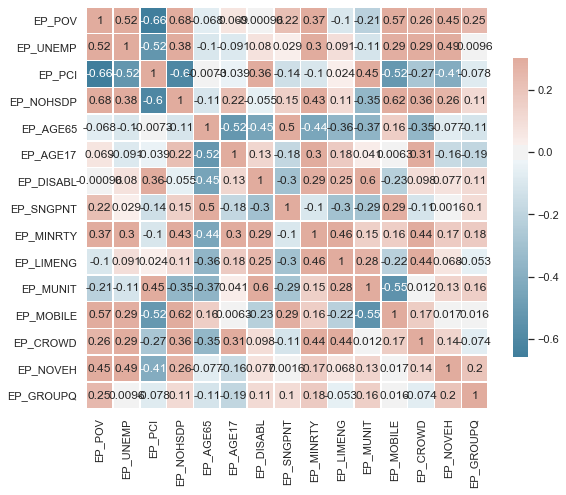

In [112]:
#plt.subplots(figsize=(10, 10))
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)
from scipy import stats
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.spearmanr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix


corr = Ready.corr(method ='spearman')
p_values = corr_sig(Ready)

mask = np.invert(np.tril(p_values < 0.05))

#print (mask)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 11))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

ax = sns.heatmap(corr, annot=True, cmap=cmap, vmax=.3, center=0, 
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#sns.heatmap(corr, mask = mask , annot=True, cmap="RdYlGn")
plt.show()

# SVI calculation 

We calculate the ratio of county value to state value by population for each SVI variables (we use EP-estimate percentage- values in the CDC data set), then we take the average of all 15 SVI variables. 

Let SVI variable set be K, where  

K = { Below Poverty, Unemployed, Income, No High School Diploma, Aged 65 or Older, Aged 17 or Younger, Civilian with a Disability, Single-Parent Households, Minority, Speaks English “Less than Well”, Multi-Unit Structures, Mobile Homes, Crowding, No Vehicle, Group Quarters }

We will use these variables in a county base and state base. While County base values are exactly same as the estimated values for these variables in the CDC website, to calculate the state base, we simply sum the county values for all of the counties in each state for each variable. Then we use the following formula to calculate the SVI value for each county.

Let $S$ is the set of states and $j$ is a county in the state $s$, where $s \in S$, $c^k_j$ SVI variable $k \in K$ value for county j, and $c_s$ SVI variable value for state s.

$SVI_j = \frac{1}{15}\sum_{k \in K} \frac{c^k_j}{c^k_s}$


In [113]:

from collections import Counter
# Sum all SVI variable values for each county
SVI_county_sum = dict(Counter(E_POV_Prop) + Counter(E_UNEMP_Prop) + Counter(E_PCI_Prop) + Counter(E_NOHSDP_Prop) + Counter(E_AGE65_Prop) + Counter(E_AGE17_Prop) + Counter(E_DISABL_Prop) + Counter(E_SNGPNT_Prop) + Counter(E_MINRTY_Prop) + Counter(E_LIMENG_Prop) + Counter(E_MUNIT_Prop) + Counter(E_MOBILE_Prop) + Counter(E_CROWD_Prop) + Counter(E_NOVEH_Prop) + Counter(E_GROUPQ_Prop))

# Divide the sum of all SVI variable values
SVI_county = {j: SVI_county_sum[j]/15 for j in SVI_county_sum }


In [114]:
# Sum all SVI variable values for each county
SVI_county_sum_no_race = dict(Counter(E_POV_Prop) + Counter(E_UNEMP_Prop) + Counter(E_PCI_Prop) + Counter(E_NOHSDP_Prop) + Counter(E_AGE65_Prop) + Counter(E_AGE17_Prop) + Counter(E_DISABL_Prop) + Counter(E_SNGPNT_Prop) + Counter(E_LIMENG_Prop) + Counter(E_MUNIT_Prop) + Counter(E_MOBILE_Prop) + Counter(E_CROWD_Prop) + Counter(E_NOVEH_Prop) + Counter(E_GROUPQ_Prop))

# Divide the sum of all SVI variable values
SVI_county_no_race = {j: SVI_county_sum[j]/14 for j in SVI_county_sum }


# Proportional Allocation

We consider allocating 1 million CHW over the states proportional to Medicaid enrollment in each state. Further, we allocate CHW to counties in each state proportional to different county vulnerability criterias as follow.

- MEDICAID
- SVI
- YPLL
- UNEMPLOYMENT
- LAST 14 DAYS COVID CASES
- LAST 14 DAYS COVID CASES / POP
- COVID DEATHS / POP

To calculate the total number of allocated CHW to per county according to these vulnerability criterias, we define the following function called "Proportional_allocation", in which we multiply the CHW allocated to each state with the ratio of the chosen vulnerability criteria of the county to the chosen vulnerability criteria of the state, the function return a dictionary with the counties as keys and the number of CHW allocated to each county for the chosen vulnerability criteria as values. 

In [115]:
def Proportional_allocation(county_level, state_level, state_budget):
    prop_allocate = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            #print (j,s, county_level[j],state_level[s], state_budget[s])
            prop_allocate[j,s] = (float(county_level[j])/float(state_level[s]))*float(state_budget[s])
        
        else:
            prop_allocate[j,s] = 0
            
    
    return prop_allocate

In [116]:
def total_state_pop(dict_1):
    state_dict = {}
    for s in State:
        state_dict [s] = sum(float(dict_1[j]*Firstphase_county[j]) for j in dict_1 if (j,s) in cartesian_pro_county_state)  
    return state_dict



In [117]:
def Proportional_allocation_pop(county_level, state_budget):
    prop_allocate = {}
    state_level = total_state_pop(county_level)
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            #print (j,s, county_level[j],state_level[s], Firstphase_county[j], state_budget[s])
            prop_allocate[j,s] = ((float(county_level[j])*Firstphase_county[j])/float(state_level[s]))*float(state_budget[s])
        
        else:
            prop_allocate[j,s] = 0
            
    
    return prop_allocate

In [118]:
# Proportional allocation according to SVI score in each county
Proportional_to_SVI = Proportional_allocation_pop(SVI_county, Vaccine_budget_state)

In [119]:
#print ('Med', Medicaid_demand[35039])
#print ('Med', Medicaid_demand[4017], 'Pop', population_county[4017], 'Med_capita', 100000*(Medicaid_demand[4017]/population_county[4017]))

In [120]:
# Dictionaries for the different vulnerability criteria values for states

# Dictionary for total Medicaid patient numbers for each state
# Medicaid_demand_state = total_state(Medicaid_demand) 

# Dictionary for total positive COVID cases for last 14 days in each state
#Covid_state = total_state(COVID_14days) 

# Dictionary for total SVI values for each state
SVI_State = total_state(SVI_county) 


# Dictionary for total SVI values for each state
SVI_State_no_race = total_state(SVI_county_no_race) 

# Dictionary for total YPLL values for each state
#YPLL_state = total_state(YPLL) 

 

In [121]:
for j in location:
    print (j , SVI_county[j], SVI_county_no_race[j])

1001 0.011992025825516868 0.012848599098768074
1003 0.017986340550437897 0.01927107916118346
1005 0.02198715862941154 0.023557669960083794
1007 0.015168199992439828 0.016251642849042673
1009 0.012828962815883246 0.01374531730273205
1011 0.016595765678414608 0.017781177512587083
1013 0.012564266077926666 0.013461713654921428
1015 0.0146790752634707 0.015727580639432893
1017 0.016153071699143835 0.017306862534796966
1019 0.011285050477350145 0.012091125511446584
1021 0.014603157345914712 0.01564624001348005
1023 0.013513209608256926 0.014478438865989565
1025 0.014185391470020436 0.015198633717879039
1027 0.01108100561582548 0.011872506016955872
1029 0.011150340611116288 0.011946793511910308
1031 0.012827395268486946 0.013743637787664586
1033 0.010639483039656644 0.011399446113917832
1035 0.01179844037489362 0.01264118611595745
1037 0.01279579706096711 0.013709782565321902
1039 0.0124751897289012 0.013366274709537
1041 0.011691984686170009 0.012527126449467867
1043 0.012601312890266963 0.

20093 0.010653559095358194 0.011414527602169492
20095 0.007102073522346994 0.007609364488228922
20097 0.008806320161224472 0.009435343029883362
20099 0.009419796710837687 0.010092639333040379
20101 0.0058741617007742105 0.0062937446794009404
20103 0.01035598798420831 0.011095701411651763
20105 0.006625205620558764 0.007098434593455819
20107 0.008949775836640759 0.009589045539257957
20109 0.006709993744781294 0.007189279012265673
20111 0.013819638418381361 0.014806755448265745
20113 0.008221534562933891 0.008808787031714883
20115 0.00796834475449009 0.008537512236953669
20117 0.006545910525060428 0.007013475562564744
20119 0.008759854166521462 0.00938555803555871
20121 0.006764158587121303 0.007247312771915682
20123 0.0071887611068574145 0.007702244043061516
20125 0.011205310525934624 0.012005689849215668
20127 0.006758386194132786 0.007241128065142271
20129 0.009404934795244015 0.010076715852047159
20131 0.006710739523449762 0.007190078060839031
20133 0.009985301431980148 0.01069853724

37111 0.008988803262179525 0.009630860638049491
37113 0.007913334234375279 0.008478572393973512
37115 0.008308269359503476 0.008901717170896582
37117 0.00904568098915764 0.009691801059811756
37119 0.01964709273872916 0.021050456505781242
37121 0.007432563922108304 0.00796346134511604
37123 0.010828344600656261 0.011601797786417423
37125 0.00840343379461327 0.009003679065657074
37127 0.010001638593537605 0.010716041350218862
37129 0.01103652669737543 0.011824850032902246
37131 0.009712485119265637 0.01040623405635604
37133 0.010975499802453327 0.011759464074057136
37135 0.012433374126286948 0.013321472278164588
37137 0.009032648955540599 0.009677838166650642
37139 0.009714643869782482 0.010408547003338374
37141 0.008470929534636584 0.00907599592996777
37143 0.007833149719768097 0.008392660414037247
37145 0.008287099049161037 0.008879034695529683
37147 0.012611821806598412 0.01351266622135544
37149 0.008069881056862151 0.008646301132352305
37151 0.00987870740750828 0.010584329365187441
3

51071 0.005373647005406545 0.0057574789343641545
51073 0.004702870880605724 0.005038790229220419
51075 0.0052130315336309605 0.0055853909288903145
51077 0.007230151240599034 0.007746590614927537
51079 0.0057466786442773145 0.0061571556902971225
51081 0.009837733887501471 0.010540429165180148
51083 0.007079012163657483 0.0075846558896330175
51085 0.005073048134688884 0.00543540871573809
51087 0.009424867378830935 0.010098072191604574
51089 0.008068696918485508 0.008645032412663045
51091 0.004741333293110385 0.005079999956903984
51093 0.006371238955544094 0.006826327452368672
51095 0.006248979693398841 0.006695335385784472
51097 0.005479224954933937 0.005870598166000647
51099 0.00472957789031715 0.005067404882482661
51101 0.004249111288979018 0.004552619238191805
51103 0.0060653699336258565 0.00649861064317056
51105 0.008300996136384976 0.008893924431841045
51107 0.009876249038707931 0.01058169539861564
51109 0.00651314149993576 0.006978365892788315
51111 0.007869382406538566 0.008431481

In [122]:
for s in State:
    print (s, SVI_State[s], SVI_State_no_race[s])

Alabama 0.9999999999999996 1.0714285714285714
Alaska 1.0000000000000002 1.0714285714285714
Arizona 1.0000000000000002 1.0714285714285714
Arkansas 0.9999999999999999 1.0714285714285712
California 0.9999999999999997 1.0714285714285716
Colorado 0.9999999999999999 1.0714285714285718
Connecticut 1.0000000000000002 1.0714285714285714
Delaware 1.0 1.0714285714285712
District of Columbia 1.0 1.0714285714285714
Florida 1.0 1.0714285714285714
Georgia 0.9999999999999998 1.071428571428571
Hawaii 1.0 1.0714285714285714
Idaho 0.9999999999999999 1.0714285714285714
Illinois 0.9999999999999999 1.071428571428572
Indiana 1.0000000000000002 1.0714285714285716
Iowa 0.9999999999999998 1.0714285714285714
Kansas 1.0000000000000002 1.0714285714285716
Kentucky 1.0000000000000002 1.0714285714285714
Louisiana 1.0 1.0714285714285714
Maine 1.0 1.0714285714285714
Maryland 1.0 1.0714285714285714
Massachusetts 1.0 1.0714285714285716
Michigan 1.0 1.0714285714285716
Minnesota 0.9999999999999999 1.0714285714285712
Missis

# 1 million CHW allocation to states

We allocate 1 million CHWs to states proportional to total Medicaid enrolles in each state.

Let's $FedCHW$ represents the number of CHW will be allocated within states by the federal government, which is 1 million in our project. $TotMed$ represents the total Medicaid enrollee numbers over the US, $Med_s$ is the total Medicaid enrollee numbers in state $s \in S$, and $CHW_s$ is the total number of CHW allocated to state $ s\in S$. 

$CHW_s = FedCHW*\frac{Med_s}{TotMed}$



# Proportional allocation for different vulnerability values

Let V = {Medicaid, SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita, SVI and Medicaid, YPLL and Medicaid, Unemployment and Medicaid, COVID and Medicaid, COVID_capita and Medicaid, COVID_death and Medicaid and COVID_death capita and Medicaid}. We assume $v_j$ represent the vulnerability value for county $j \in J$, while $v_s$ represent the sum of the vulnerability values for each county in the state of county j.

$Prop_{v_j} = \frac{v_j}{v_s}*CHW_s$



In [123]:
Vaccine_budget_state

{'Alabama': 137475,
 'Alaska': 62400,
 'Arizona': 195975,
 'Arkansas': 85800,
 'California': 1090050,
 'Colorado': 156000,
 'Connecticut': 104325,
 'Delaware': 28275,
 'District of Columbia': 22425,
 'Florida': 596700,
 'Georgia': 282750,
 'Hawaii': 41925,
 'Idaho': 45825,
 'Illinois': 284700,
 'Indiana': 185250,
 'Iowa': 88725,
 'Kansas': 81900,
 'Kentucky': 126750,
 'Louisiana': 131625,
 'Maine': 40950,
 'Maryland': 169650,
 'Massachusetts': 199875,
 'Michigan': 282750,
 'Minnesota': 156000,
 'Mississippi': 82875,
 'Missouri': 172575,
 'Montana': 32175,
 'Nebraska': 54600,
 'Nevada': 82875,
 'New Hampshire': 40950,
 'New Jersey': 251550,
 'New Mexico': 59475,
 'New York': 563550,
 'North Carolina': 286650,
 'North Dakota': 22425,
 'Ohio': 328575,
 'Oklahoma': 109200,
 'Oregon': 117975,
 'Pennsylvania': 370500,
 'Rhode Island': 32175,
 'South Carolina': 142350,
 'South Dakota': 26325,
 'Tennessee': 188175,
 'Texas': 746850,
 'Utah': 78000,
 'Vermont': 20475,
 'Virginia': 238875,
 'Was

In [124]:
# Calling proportional allocation function for different vulnerability criterias



# Proportional allocation according to SVI score in each county
Proportional_to_Adult_pop = Proportional_allocation(Adult_pop_county, Adult_pop_state, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_Firstphase = Proportional_allocation(Firstphase_county, Firstphase_State, Vaccine_budget_state)


# Proportional allocation according to SVI score in each county
Proportional_to_ADI = Proportional_allocation_pop(ADI_county, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_PVI = Proportional_allocation_pop(PVI_county, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_SVI = Proportional_allocation_pop(SVI_county, Vaccine_budget_state)

# Proportional allocation according to YPLL in each county
Proportional_to_SVI_no_race = Proportional_allocation_pop(SVI_county_no_race, Vaccine_budget_state)


# Normalize values for comparison
To be able compare the different vulnerability values for each county, we normalize all vulnerability values as follows. 

Let $m_{v_s} = \min \{v_j, \text{ for county j in state s }\}$  and 
$M_{v_s} = \max \{v_j, \text{ for county j in state s }\}$.

We calculate the normalize value for each vulnerability for each county by substracting the min vulnerability in the state of the county and dividing that by the differences between max and min value of the vulnerability values in the state. Mathematical formulation for the normalization is as follows.

$N_{v_j} = \frac{v_j - m_{v_s}}{M_{v_s} - m_{v_s}}$ 

for each $v \in V$, where V = {Medicaid, SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita, SVI and Medicaid, YPLL and Medicaid, Unemployment and Medicaid, COVID and Medicaid, COVID_capita and Medicaid, COVID_death and Medicaid and COVID_death capita and Medicaid}, j is a county in each state $s \in S$.


In [125]:
#Normalize function to normalize the vulnerability values to be able to compare them

def normalize(dict_1):
    
    result = {}
    min_data = {s: min(dict_1[j] for j in location if (j,s) in cartesian_pro_county_state) for s in State }
    max_data = {s: max(dict_1[j] for j in location if (j,s) in cartesian_pro_county_state) for s in State }
    
    for (j,s) in cartesian_pro_county_state:
        
        if (max_data[s] - min_data[s]) != 0 :
    
            result[j] = (dict_1[j] - min_data[s])/(max_data[s] - min_data[s])
        
        else:
            result[j] = 1
    
    return result 

# Percentile Rank

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html"> The function scipy.stats.percentileofscore (a, score, kind='rank')   </a>
computes the percentile rank of a score relative to a list of scores. 
"rank": Average percentage ranking of score. In case of multiple matches, average the percentage rankings of all matching scores.

In [126]:
from scipy import stats

# Calculate percentile ranks

def percentile_ranks(data):
    x = {s: [] for s in State}

    for (j,s) in cartesian_pro_county_state:
         
        x[s].append(data[j])
    
    
    
    percentile_ranks = {i: stats.percentileofscore(x[s], data[i], 'rank') for (i,s) in cartesian_pro_county_state}

    return percentile_ranks

In [127]:
# Write timestamp 

time_stamp = time.strftime('%m-%d-%Y %H:%M:%S')
with open('Output/time_stamp.csv','w') as f:
    w = csv.writer(f)
    now = time.strftime('%m/%d/%Y %H:%M:%S')
    w.writerow(['time',now])
    

In [128]:
#print (Medicaid_demand)

In [129]:
#Write a function to order the dicts
def order_k(dict_1):
    dict_2 = {}
    for m in location:
        if m in dict_1.keys():
            dict_2[m] = dict_1[m]
        else:
            dict_2[m] = 0
    
    return dict_2
            

In [130]:
Adult_pop_county = order_k(Adult_pop_county)
ADI_county = order_k(ADI_county)#{m: SVI_county[m] for m in location}
PVI_county = order_k(PVI_county)#{m: SVI_county[m] for m in location}

SVI_county = order_k(SVI_county)#{m: SVI_county[m] for m in location}
SVI_county_no_race = order_k(SVI_county_no_race)#{m: SVI_county[m] for m in location}
Firstphase_county = order_k(Firstphase_county)



In [131]:
# Write file allocation with each strategies for each county 

Strategies = ["Adult_pop", "Firstphase", "ADI", "PVI" , "SVI", "SVI_no_race"]

fieldnames = []  
fieldnames.append('County_FIPS')


SVI_values = {i:SVI_county[i] for i in location}
s_count = 1
for s in Strategies:   
    fieldnames.append('Proportional_allocation_to_' + s)
    fieldnames.append(s)
    fieldnames.append('Percentile_ranks_' + s)

    
        

writefile = 'Output/County_level_proportional_vaccine_allocation.csv'
with open( writefile, 'w' ) as f:
    writer = csv.writer(f)                
    writer.writerow(fieldnames)
    for row in zip(location
                   , Proportional_to_Adult_pop.values(),        Adult_pop_county.values(),            percentile_ranks(Adult_pop_county).values()
                   , Proportional_to_Firstphase.values(),       Firstphase_county.values(),    percentile_ranks(Firstphase_county).values()
                   , Proportional_to_ADI.values(),              ADI_county.values(),           percentile_ranks(ADI_county).values()
                   , Proportional_to_PVI.values(),              PVI_county.values(),           percentile_ranks(PVI_county).values()
                   , Proportional_to_SVI.values(),              SVI_county.values(),           percentile_ranks(SVI_county).values()
                   , Proportional_to_SVI_no_race.values(),      SVI_county_no_race.values(),   percentile_ranks(SVI_county_no_race).values()
                    ):                    
       
        writer.writerow(row)

In [132]:
Vaccine_state = {s: Vaccine_budget_state[s] for s in State}

In [133]:
writefile = 'Output/State_level_vaccine_allocation.csv'

cl = ['State', 'Vaccine_allocation']
with open( writefile, 'w' ) as f:
    writer = csv.writer(f)                
    writer.writerow(cl)
    for row in zip( State, Vaccine_state.values()):
        writer.writerow(row)